In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ikan import KANLinear, KAN #你可以这样召唤出你需要的KAN

In [3]:
import torch
from torchinfo import summary


# 定义一个 KAN 模型实例
kan_model = KAN(
    layers_hidden=[3, 64, 128, 1],  # 输入维度为 3，隐藏层维度为 64 和 128，输出维度为 1
    grid_size=5,
    spline_order=3,
    scale_noise=0.1,
    scale_base=1.0,
    scale_spline=1.0,
    base_activation=torch.nn.SiLU,
    grid_eps=0.02,
    grid_range=[-1, 1],
)

# 打印模型摘要
summary(kan_model, input_size=(3,))


Layer (type:depth-idx)                   Output Shape              Param #
KAN                                      [1]                       --
├─ModuleList: 1-1                        --                        --
│    └─KANLinear: 2-1                    [64]                      1,920
│    │    └─SiLU: 3-1                    [1, 3]                    --
│    └─KANLinear: 2-2                    [128]                     81,920
│    │    └─SiLU: 3-2                    [1, 64]                   --
│    └─KANLinear: 2-3                    [1]                       1,280
│    │    └─SiLU: 3-3                    [1, 128]                  --
Total params: 85,120
Trainable params: 85,120
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

从输出结果来看，模型结构和参数设置显示了一些细节，显示了每一层的输出形状和参数数量。以下是各层和设置之间的具体联系和解释：

### 模型设置和摘要的联系

#### 设置
```python
kan_model = KAN(
    layers_hidden=[3, 64, 128, 1],  # 输入维度为 3，隐藏层维度为 64 和 128，输出维度为 1
    grid_size=5,
    spline_order=3,
    scale_noise=0.1,
    scale_base=1.0,
    scale_spline=1.0,
    base_activation=torch.nn.SiLU,
    grid_eps=0.02,
    grid_range=[-1, 1],
)
```

#### 模型摘要
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
KAN                                      [1]                       --
├─ModuleList: 1-1                        --                        --
│    └─KANLinear: 2-1                    [64]                      1,920
│    │    └─SiLU: 3-1                    [1, 3]                    --
│    └─KANLinear: 2-2                    [128]                     81,920
│    │    └─SiLU: 3-2                    [1, 64]                   --
│    └─KANLinear: 2-3                    [1]                       1,280
│    │    └─SiLU: 3-3                    [1, 128]                  --
==========================================================================================
Total params: 85,120
Trainable params: 85,120
Non-trainable params: 0
Total mult-adds (M): 0
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
==========================================================================================
```

### 解释

#### KAN 模型实例

- `layers_hidden=[3, 64, 128, 1]`：
  - 模型的输入特征数为 3。
  - 第一层的输出特征数为 64。
  - 第二层的输出特征数为 128。
  - 最后一层的输出特征数为 1。

#### 各层的参数数量

1. **第一层 KANLinear**
   - 输入特征数为 3，输出特征数为 64。
   - 参数数量计算：
     - 基础权重：`3 * 64 = 192`。
     - 样条权重：`(3 * (5 + 3)) * 64 = 3 * 8 * 64 = 1536`。
     - 总参数数量：`192 + 1536 = 1728`（可能略有差异，因为模型中可能还有其他小的参数或偏置项）。

2. **第二层 KANLinear**
   - 输入特征数为 64，输出特征数为 128。
   - 参数数量计算：
     - 基础权重：`64 * 128 = 8192`。
     - 样条权重：`(64 * (5 + 3)) * 128 = 64 * 8 * 128 = 65536`。
     - 总参数数量：`8192 + 65536 = 73728`。

3. **第三层 KANLinear**
   - 输入特征数为 128，输出特征数为 1。
   - 参数数量计算：
     - 基础权重：`128 * 1 = 128`。
     - 样条权重：`(128 * (5 + 3)) * 1 = 128 * 8 * 1 = 1024`。
     - 总参数数量：`128 + 1024 = 1152`。

这些参数数量的计算结果与模型摘要中的参数数量一致。

#### 总参数数量
- 模型的总参数数量为 85,120。

#### 各层的输出形状
- 输入特征数为 3。
- 第一层的输出形状为 `[64]`。
- 第二层的输出形状为 `[128]`。
- 第三层的输出形状为 `[1]`。


In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 计算并打印模型参数数量
total_params = count_parameters(kan_model)
print(f"Total trainable parameters: {total_params}")

# 打印每一层的参数数量
for name, param in kan_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")

# 打印每一层的形状
for name, module in kan_model.named_modules():
    if isinstance(module, KANLinear):
        print(f"{name}: {module}")

# 示例输入
x = torch.randn(1, 3)
# 前向传播
output = kan_model(x)
print(f"Output: {output}")

Total trainable parameters: 85120
layers.0.base_weight: 192 parameters
layers.0.spline_weight: 1536 parameters
layers.0.spline_scaler: 192 parameters
layers.1.base_weight: 8192 parameters
layers.1.spline_weight: 65536 parameters
layers.1.spline_scaler: 8192 parameters
layers.2.base_weight: 128 parameters
layers.2.spline_weight: 1024 parameters
layers.2.spline_scaler: 128 parameters
layers.0: KANLinear(
  (base_activation): SiLU()
)
layers.1: KANLinear(
  (base_activation): SiLU()
)
layers.2: KANLinear(
  (base_activation): SiLU()
)
Output: tensor([[-0.0071]], grad_fn=<ViewBackward0>)


# 测试

In [6]:
import torch
dummy_input = torch.randn(1, 3)
dummy_output = kan_model(dummy_input)
print(dummy_output)
print(dummy_output.shape)


tensor([[0.0008]], grad_fn=<ViewBackward0>)
torch.Size([1, 1])


Epoch [100/300], KAN Loss: 0.1559, MLP Loss: 9.0299
Epoch [200/300], KAN Loss: 0.0987, MLP Loss: 2.8999
Epoch [300/300], KAN Loss: 0.0832, MLP Loss: 1.1950
KAN Test Loss: 0.2667
MLP Test Loss: 1.1829


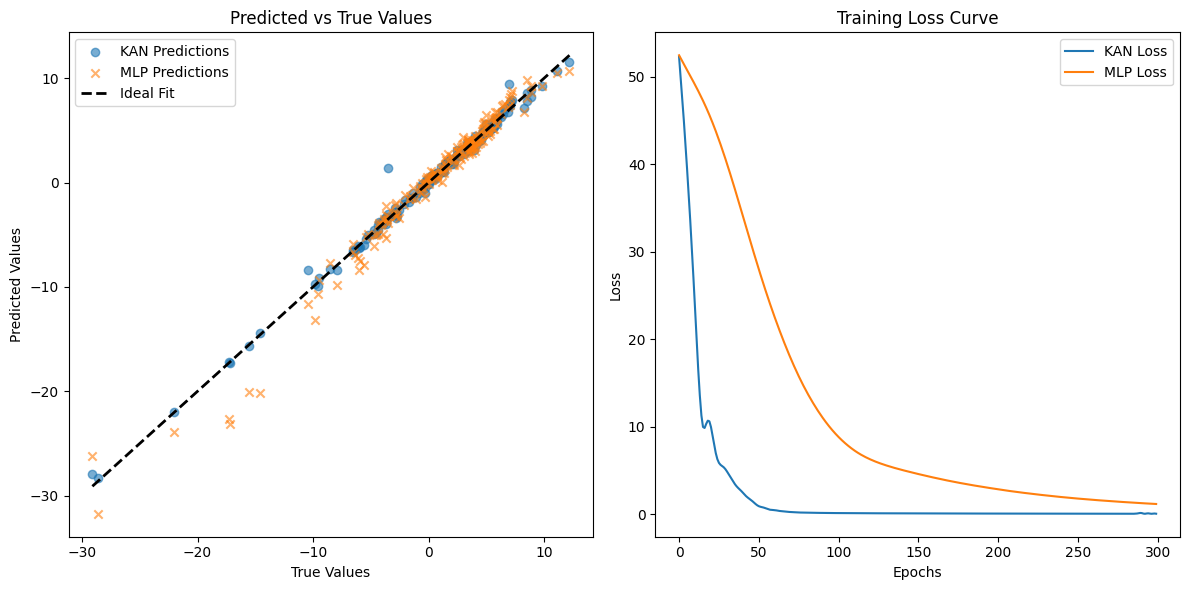

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from ikan import TaylorKAN as KAN

# 定义 KAN 模型
kan_model = KAN(
    layers_hidden=[3, 64, 128, 1],  # 输入维度为 3，隐藏层维度为 64 和 128，输出维度为 1
)

# 定义 MLP 模型
mlp_model = nn.Sequential(
    nn.Linear(3, 64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
)

# # 定义一个简单的数学等式：y = 2x1 - 3x2 + 1.5x3 + 4
# def equation(x):
#     return 2 * x[:, 0] - 3 * x[:, 1] + 1.5 * x[:, 2] + 4

# 定义一个复杂的数学等式
def equation(x):
    return (
        torch.sin(x[:, 0] * 2) + 0.5 * torch.cos(x[:, 1] * 3) -
        1.2 * x[:, 2]**2 + 3 * x[:, 0] * x[:, 1] -
        2.5 * torch.exp(-x[:, 2]) + 6
    )


# 生成数据集
torch.manual_seed(0)  # 固定随机种子
n_samples = 1000  # 样本数量
x_data = torch.randn(n_samples, 3)  # 输入数据 (1000, 3)
y_data = equation(x_data).unsqueeze(1)  # 输出数据，增加一个维度 (1000, 1)

# 数据分割
train_size = int(0.8 * n_samples)
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# 损失函数和优化器
criterion = nn.MSELoss()
kan_optimizer = optim.Adam(kan_model.parameters(), lr=0.001)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# 训练模型
epochs = 300
kan_losses = []
mlp_losses = []

for epoch in range(epochs):
    # KAN 模型训练
    kan_model.train()
    kan_optimizer.zero_grad()
    kan_pred = kan_model(x_train)
    kan_loss = criterion(kan_pred, y_train)
    kan_loss.backward()
    kan_optimizer.step()
    
    # MLP 模型训练
    mlp_model.train()
    mlp_optimizer.zero_grad()
    mlp_pred = mlp_model(x_train)
    mlp_loss = criterion(mlp_pred, y_train)
    mlp_loss.backward()
    mlp_optimizer.step()

    # 保存损失
    kan_losses.append(kan_loss.item())
    mlp_losses.append(mlp_loss.item())

    # 打印训练过程
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], KAN Loss: {kan_loss.item():.4f}, MLP Loss: {mlp_loss.item():.4f}")

# 测试模型
kan_model.eval()
mlp_model.eval()

with torch.no_grad():
    y_kan_pred = kan_model(x_test)
    y_mlp_pred = mlp_model(x_test)
    kan_test_loss = criterion(y_kan_pred, y_test)
    mlp_test_loss = criterion(y_mlp_pred, y_test)
    print(f"KAN Test Loss: {kan_test_loss.item():.4f}")
    print(f"MLP Test Loss: {mlp_test_loss.item():.4f}")


# 可视化结果
plt.figure(figsize=(12, 6))

# 真实值与预测值对比
plt.subplot(1, 2, 1)
plt.scatter(y_test.numpy(), y_kan_pred.numpy(), alpha=0.6, label='KAN Predictions')
plt.scatter(y_test.numpy(), y_mlp_pred.numpy(), alpha=0.6, label='MLP Predictions', marker='x')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.legend()

# 损失曲线
plt.subplot(1, 2, 2)
plt.plot(range(epochs), kan_losses, label='KAN Loss')
plt.plot(range(epochs), mlp_losses, label='MLP Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


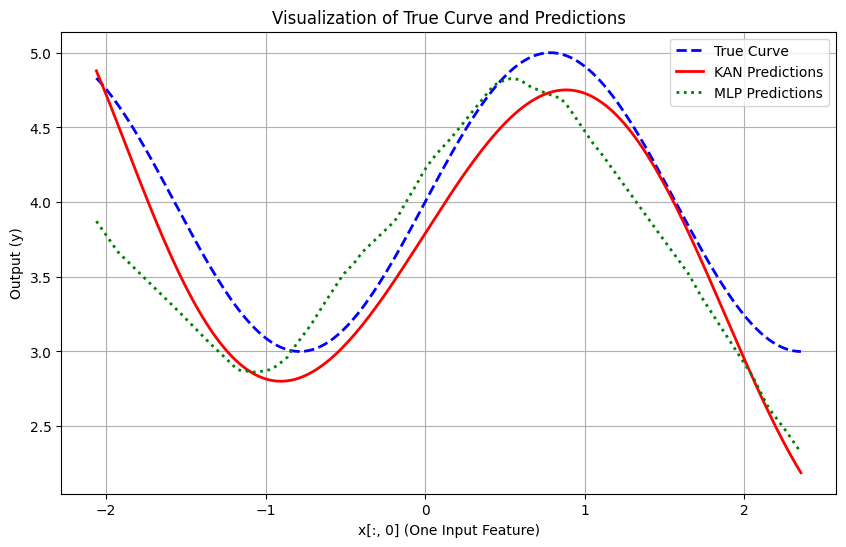

In [20]:

# 生成连续值
x_fixed = x_test.clone()  # 克隆测试数据，避免修改原数据
x_fixed[:, 1] = 0.0  # 固定 x2 为 0
x_fixed[:, 2] = 0.0  # 固定 x3 为 0

# 为 x[:, 0] 生成连续值
x_fixed[:, 0] = torch.linspace(x_test[:, 0].min(), x_test[:, 0].max(), x_test.size(0))

# 计算真实值和预测值
y_true_curve = equation(x_fixed).numpy()  # 真实值
y_kan_curve = kan_model(x_fixed).detach().numpy()  # KAN 模型预测值
y_mlp_curve = mlp_model(x_fixed).detach().numpy()  # MLP 模型预测值

# 可视化
plt.figure(figsize=(10, 6))
plt.plot(x_fixed[:, 0].numpy(), y_true_curve, label="True Curve", color="blue", linestyle="--", linewidth=2)
plt.plot(x_fixed[:, 0].numpy(), y_kan_curve, label="KAN Predictions", color="red", linestyle="-", linewidth=2)
plt.plot(x_fixed[:, 0].numpy(), y_mlp_curve, label="MLP Predictions", color="green", linestyle=":", linewidth=2)
plt.xlabel("x[:, 0] (One Input Feature)")
plt.ylabel("Output (y)")
plt.title("Visualization of True Curve and Predictions")
plt.legend()
plt.grid(True)
plt.show()

